In [1]:
!pip install -U pymoo

In [2]:
!pip install -U deslib

In [4]:
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

import numpy as np
import pickle
from time import time
import os
import sys
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import ElementwiseProblem
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import FloatRandomSampling
from deslib.des.knora_e import KNORAE
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler

In [5]:
def LoadFeatures(path):

    df_train = pd.read_csv(path+'train.csv')
    X_train = df_train.drop('Label', axis=1) 
    y_train = df_train['Label']  

    df_test = pd.read_csv(path+'test.csv')
    X_test = df_test.drop('Label', axis=1) 
    y_test = df_test['Label']  

    df_test_ev = pd.read_csv(path+'test_evento.csv')
    #df_test_ev = df_test_ev.sample(frac=1).reset_index(drop=True)
    X_test_ev = df_test_ev.drop('Label', axis=1) 
    y_test_ev = df_test_ev['Label']  

    #return X_train, y_train, X_test[:1000], y_test[:1000], X_test_ev[:1000], y_test_ev[:1000]
    return X_train, y_train, X_test, y_test, X_test_ev, y_test_ev

In [9]:
# Definir o problema
class MyProblem(ElementwiseProblem):

    def __init__(self, *args):

        self.X_train = args[0]
        self.y_train = args[1]
        self.X_test = args[2]
        self.y_test = args[3]
        self.X_test_ev = args[4]
        self.y_test_ev = args[5]
        
        super().__init__(n_var=31,                 # Número de variáveis de decisão
                         n_obj=2,                 # Número de funções objetivo
                         n_constr=0,              # Número de restrições (se houver)
                         xl=np.zeros(31),     # Limites inferiores para cada variável
                         xu=np.ones(31))     # Limites superiores para cada variável


    # x = matriz com as variáveis definidas pelo algoritmo NSGA2.
    # out = retorna o resultado dos objetivos [acurácia e tempo].
    def _evaluate(self, x, out, *args, **kwargs):

        X_train = self.X_train
        y_train = self.y_train
        X_test = self.X_test
        y_test = self.y_test
        X_test_ev = self.X_test_ev
        y_test_ev = self.y_test_ev
        
        X_train, X_test, X_test_ev = self.AdjustFeatures(x, X_train, X_test, X_test_ev)

        f1, f2 = self.EvaluateModelErrorTime(X_train, X_test, X_test_ev, y_train, y_test, y_test_ev)

        # f1 = acurácia
        # f2 = tempo de inferência
        out["F"] = [f1, f2]

    def AdjustFeatures(self, x, x_train, x_test, x_test_ev):

        for i in range(len(x) -1, 0 , -1):
            if self.IsToDeleteFeature(x[i]):
                x_train = np.delete(x_train, i, 1)
                x_test = np.delete(x_test, i, 1)
                x_test_ev = np.delete(x_test_ev, i, 1)                
        return x_train, x_test, x_test_ev

    def IsToDeleteFeature(self,feature_value):
        return feature_value < 0.5

    def EvaluateModelErrorTime(self, x_train, x_test, x_test_ev, y_train, y_test, y_test_ev):

        y_pred, y_test, y_pred_ev, y_test_ev= self.GetPredictedClassification(x_train, x_test, x_test_ev, y_train, y_test, y_test_ev)

        accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
        accuracy2 = accuracy_score(y_true=y_test_ev, y_pred=y_pred_ev)
        
        print(f'Acurácia: {accuracy * 100:.4f}%')
        print(f'Acurácia Evento: {accuracy2 * 100:.4f}%')
        
        return (1 - accuracy, 1 - accuracy2)
    
    def GetPredictedClassification(self, x_train, x_test, x_test_ev, y_train, y_test, y_test_ev):
   
        model = RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=16)
        model.fit(X=x_train, y=y_train)

        knorae = KNORAE(model)

        knorae.fit(x_train, y_train)
        
        #t0 = time()
        y_test_predict = knorae.predict(x_test)
        y_test_predict_ev = knorae.predict(x_test_ev)

        return y_test_predict, y_test, y_test_predict_ev, y_test_ev

In [59]:
def Minimize(problem):
    
    algorithm = NSGA2(pop_size=100, sampling=FloatRandomSampling())
    
    res = minimize(problem,
                   algorithm,
                   ('n_gen', 100),
                   seed=16,
                   verbose=True,
                   save_history=True)
    
    return res

In [93]:
def plotar(res):

    # ordena o resultado pela acurácia.
    res_sorted = res.F[res.F[:, 1].argsort()]
 
    plt.figure(figsize=(4.2, 4.2))

    # Índice da solução com o menor valor para o primeiro objetivo


    # Coordenadas da melhor solução
    best_solution = res.F[3]

    # Destacar a melhor solução
    plt.scatter(
        best_solution[1], best_solution[0],
        color="red", label="Melhor solução", zorder=5
    )
    
    plt.plot(res_sorted[:, 1], res_sorted[:, 0], color='orange', linewidth=2)
    plt.xticks(rotation=45, ha='right')
    plt.autoscale(tight=True)
    
    plt.xlabel("Acurácia - Eventos")
    plt.ylabel("Acurácia - Eventos Não Utilizados", labelpad=1)
    plt.tick_params(axis='both', which='major', pad=0) 
    
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}'))
    plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}'))
    
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()

In [105]:
def plotar2(res, indice):

    # ordena o resultado pela acurácia.
    res_sorted = res.F[res.F[:, 1].argsort()]
 
    plt.figure(figsize=(4.2, 4.2))

    # Coordenadas da melhor solução
    best_solution = res.F[indice]

    print(indice, best_solution[0], best_solution[1])
    # Destacar a melhor solução
    plt.scatter(
        best_solution[1], best_solution[0],
        color="red", label="Melhor solução", zorder=5
    )
    
    plt.plot(res_sorted[:, 1], res_sorted[:, 0], color='orange', linewidth=2)
    plt.xticks(rotation=45, ha='right')
    plt.autoscale(tight=True)
    
    plt.xlabel("Acurácia - Eventos")
    plt.ylabel("Acurácia - Eventos Não Utilizados", labelpad=1)
    plt.tick_params(axis='both', which='major', pad=0) 
    
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}'))
    plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}'))
    
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()

# name: MyProblem
# n_var: 31
# n_obj: 2
# n_ieq_constr: 0
# n_eq_constr: 0

Acurácia: 93.4244%
Acurácia Evento: 97.3928%
Acurácia: 1.1498%
Acurácia Evento: 2.0265%
Acurácia: 93.1391%
Acurácia Evento: 97.4024%
Acurácia: 70.5929%
Acurácia Evento: 2.9324%
Acurácia: 93.5191%
Acurácia Evento: 97.2428%
Acurácia: 93.3712%
Acurácia Evento: 97.3928%
Acurácia: 70.4555%
Acurácia Evento: 18.2012%
Acurácia: 93.3531%
Acurácia Evento: 3.0007%
Acurácia: 93.4232%
Acurácia Evento: 97.3940%
Acurácia: 93.4659%
Acurácia Evento: 97.3316%
Acurácia: 93.5208%
Acurácia Evento: 85.0179%
Acurácia: 93.4974%
Acurácia Evento: 97.3604%
Acurácia: 93.4945%
Acurácia Evento: 33.9248%
Acurácia: 24.3823%
Acurácia Evento: 2.1717%
Acurácia: 93.4244%
Acurácia Evento: 97.3928%
Acurácia: 70.7203%
Acurácia Evento: 50.4967%
Acurácia: 70.3778%
Acurácia Evento: 49.4877%
Acurácia: 93.5787%
Acurácia Evento: 98.2147%
Acurácia: 99.6171%
Acurácia Evento: 98.2363%
Acurácia: 70.5526%
Acurácia Evento: 49.4889%
Acurácia: 93.6851%
Acurácia 

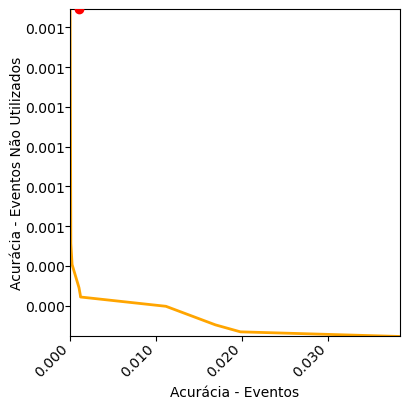

In [63]:
path = 'dataset/eventos_dataset_ok/exp1/'
X_train, y_train, X_test, y_test, X_test_ev, y_test_ev = LoadFeatures(path)

X_train.shape

# Normalizar os dados entre 0 e 1
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_test_ev = scaler.fit_transform(X_test_ev)

problem = MyProblem(X_train, y_train, X_test, y_test, X_test_ev, y_test_ev)
print(problem)

res1 = Minimize(problem)
print(res1.F)
plotar(res1)

In [17]:
res1.F

array([[7.30690766e-04, 2.75958054e-04],
       [1.13987759e-03, 1.31979939e-04],
       [9.93739442e-04, 1.55976292e-04],
       [3.27349463e-04, 1.17582128e-03],
       [4.38414459e-04, 1.12782857e-03],
       [6.19625769e-04, 9.47855926e-04],
       [1.36785311e-03, 1.19981763e-05],
       [1.91733257e-03, 0.00000000e+00],
       [3.27349463e-04, 1.17582128e-03]])

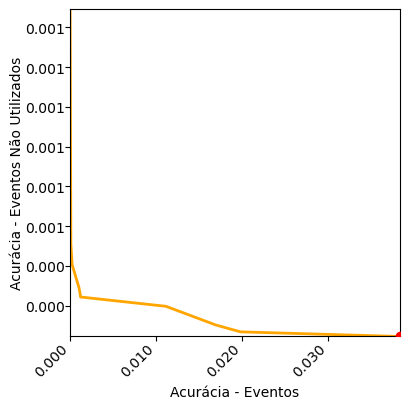

In [95]:
plotar(res1)

In [27]:
res1.F[0]

array([0.00073069, 0.00027596])

In [35]:
res1.F[0][1]

0.0002759580543757467

In [45]:
res1.X

array([[0.49784288, 0.31397447, 0.19235999, 0.7510931 , 0.74773248,
        0.17710741, 0.48425182, 0.85060409, 0.93970925, 0.95489981,
        0.30359996, 0.16492753, 0.28709382, 0.13031   , 0.96046498,
        0.76562123, 0.64545884, 0.2209301 , 0.6517499 , 0.97768092,
        0.68203164, 0.35903709, 0.41548102, 0.81623415, 0.09292495,
        0.8610396 , 0.96216814, 0.48591771, 0.48996499, 0.99437839,
        0.77598046],
       [0.44279048, 0.77948479, 0.91167288, 0.5636558 , 0.0868309 ,
        0.53010168, 0.67754032, 0.36074046, 0.79575916, 0.53363357,
        0.91536226, 0.66168547, 0.48645579, 0.33495514, 0.98492114,
        0.46956549, 0.02180103, 0.07062669, 0.19732311, 0.56686473,
        0.96385878, 0.20559315, 0.11057585, 0.226404  , 0.05092293,
        0.77979354, 0.76444537, 0.67781192, 0.29338699, 0.426714  ,
        0.85987381],
       [0.41299838, 0.3628196 , 0.45112367, 0.98417607, 0.77541474,
        0.17527143, 0.85492258, 0.30362066, 0.88822494, 0.43610754,
      

In [65]:
len(res1.F)

100

In [67]:
len(X_train)

6636

In [77]:
X_train.shape

(6636, 31)

In [79]:
path = 'dataset/eventos_dataset_ok/exp1/'
aX_train, ay_train, aX_test, ay_test, aX_test_ev, ay_test_ev = LoadFeatures(path)

In [81]:
aX_train.shape

(6636, 31)

In [87]:
len(aX_train.columns)

31

0 0.0010463491766576904 0.0


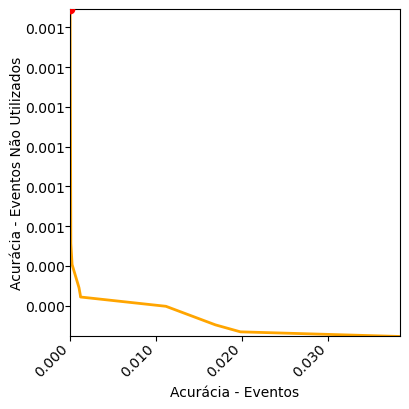

1 0.0010463491766576904 0.0


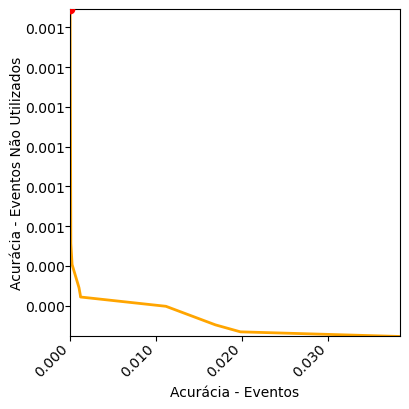

2 0.00022212999281001622 0.038346171381949956


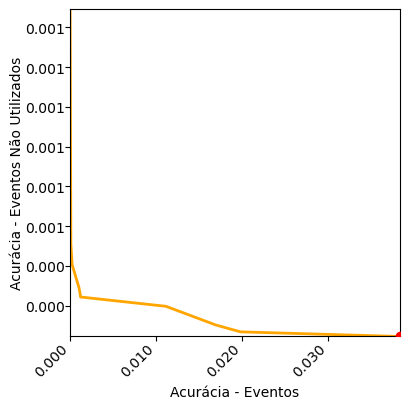

3 0.00022212999281001622 0.038346171381949956


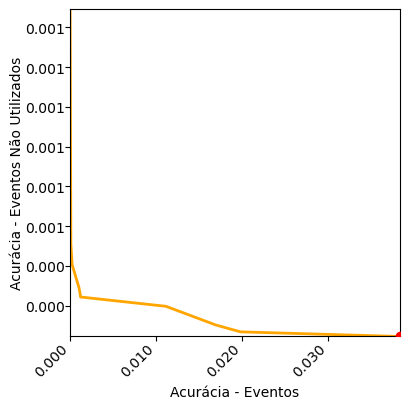

4 0.00045595103787321456 8.398723394043017e-05


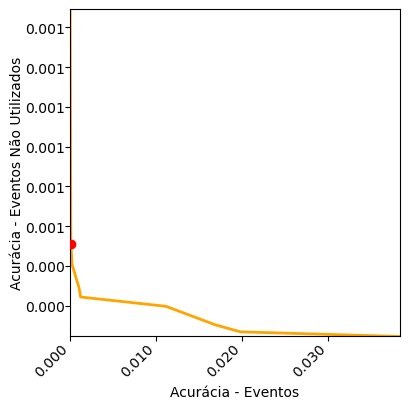

5 0.00023382104506319834 0.01979699085738973


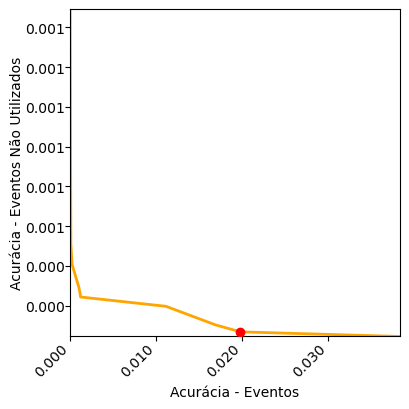

6 0.00029812183245547796 0.011134307585247027


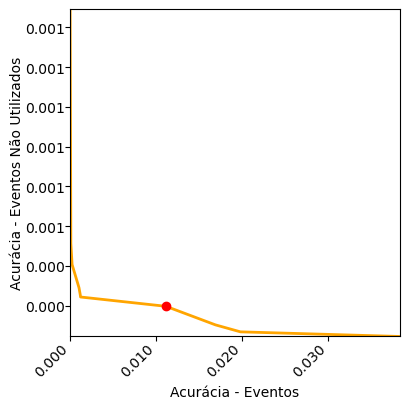

7 0.0003215039369618422 0.0012118158039977622


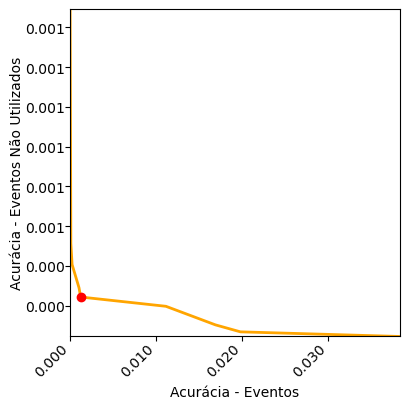

8 0.00029812183245547796 0.011134307585247027


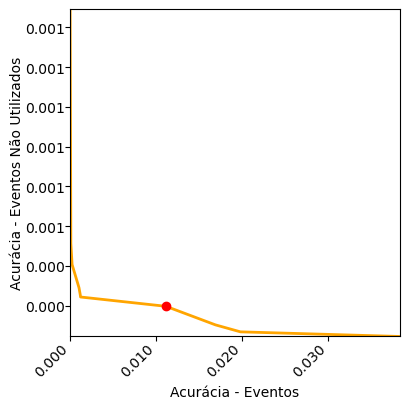

9 0.0002513576234428605 0.016893432198305858


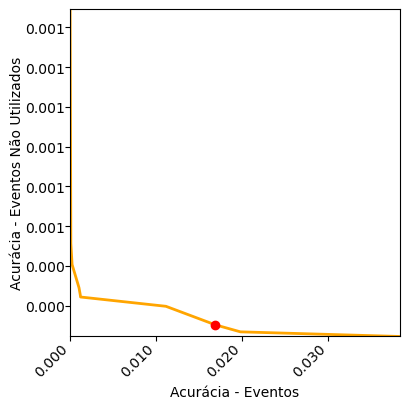

10 0.0002513576234428605 0.016893432198305858


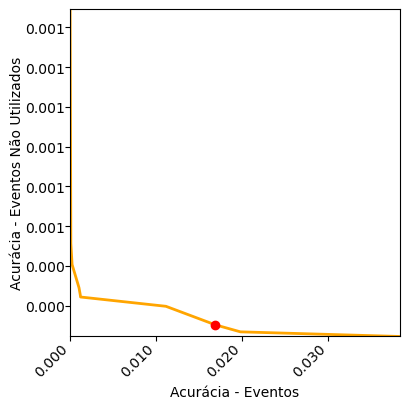

11 0.00023382104506319834 0.01979699085738973


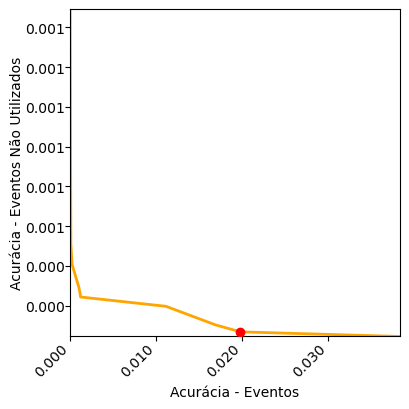

12 0.00040334130273400604 0.00022796534926694534


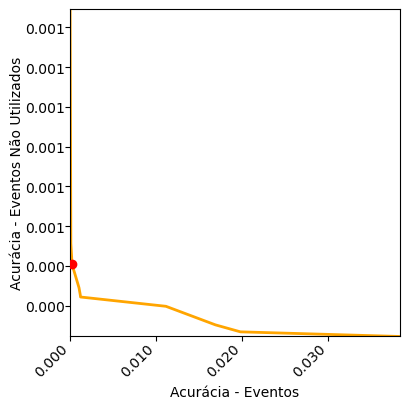

13 0.00040334130273400604 0.00022796534926694534


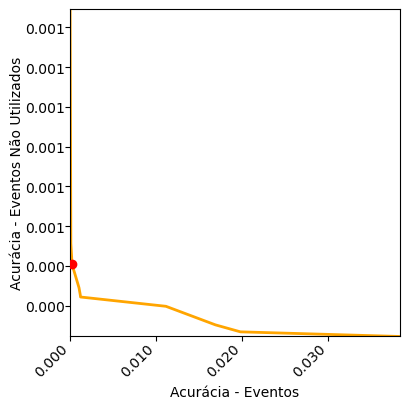

14 0.00034488604146820645 0.0010318431598397293


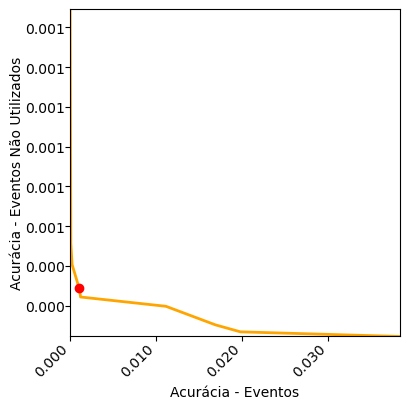

15 0.00045595103787321456 8.398723394043017e-05


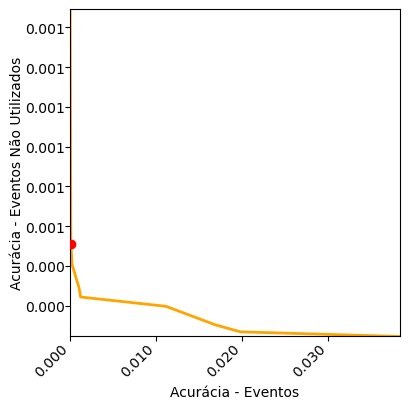

16 0.00034488604146820645 0.0010318431598397293


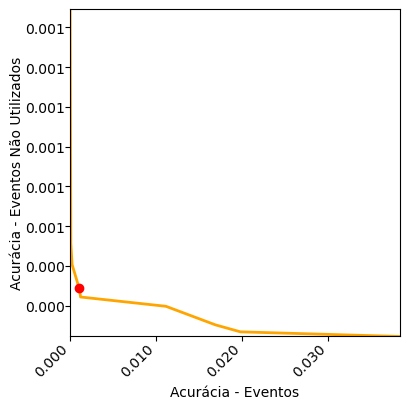

17 0.0003215039369618422 0.0012118158039977622


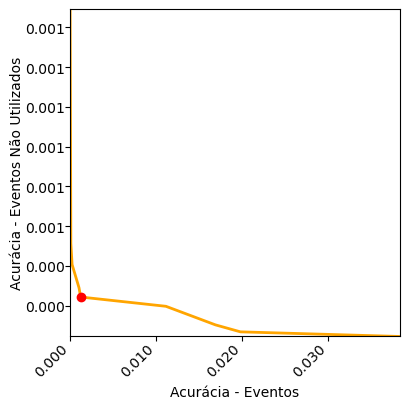

18 0.00032734946308843327 0.0011758212751661334


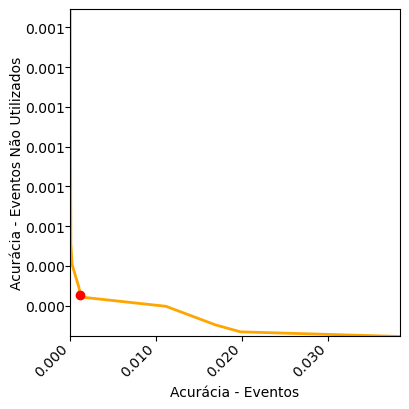

19 0.00032734946308843327 0.0011758212751661334


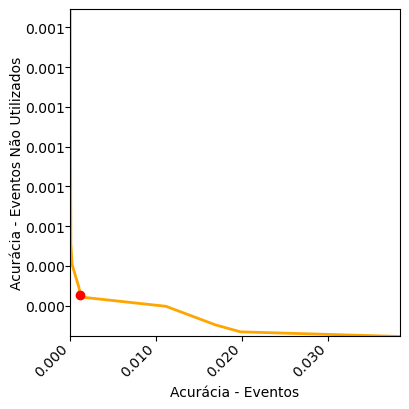

20 0.00034488604146820645 0.0010318431598397293


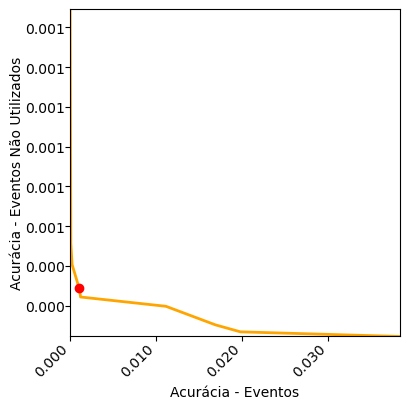

21 0.00032734946308843327 0.0011758212751661334


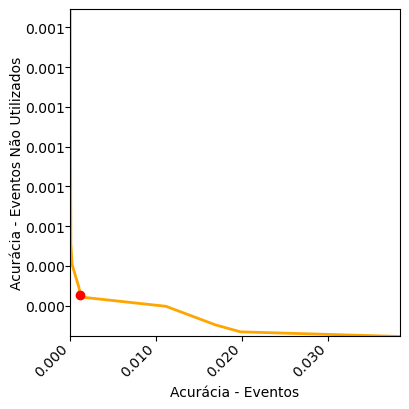

22 0.0003215039369618422 0.0012118158039977622


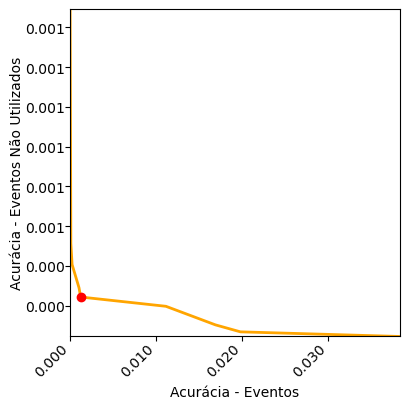

23 0.00023382104506319834 0.01979699085738973


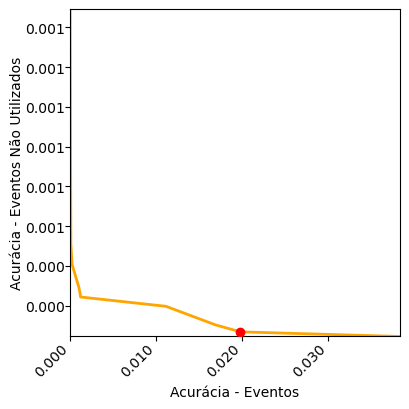

24 0.00032734946308843327 0.0011758212751661334


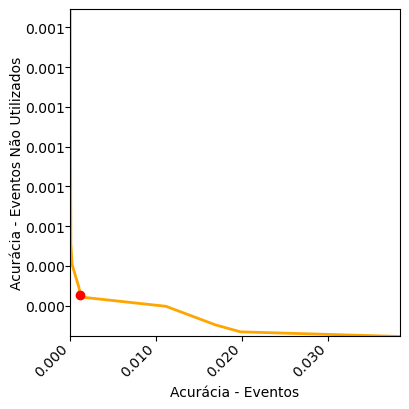

25 0.00032734946308843327 0.0011758212751661334


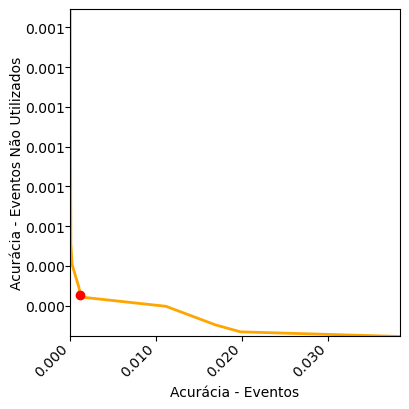

26 0.00032734946308843327 0.0011758212751661334


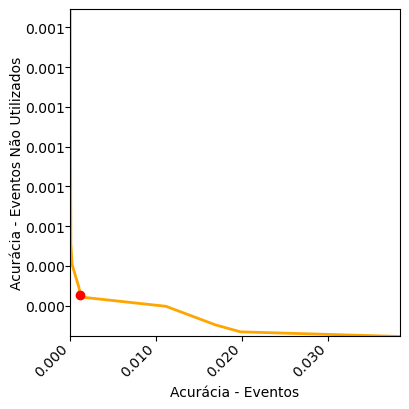

27 0.00032734946308843327 0.0011758212751661334


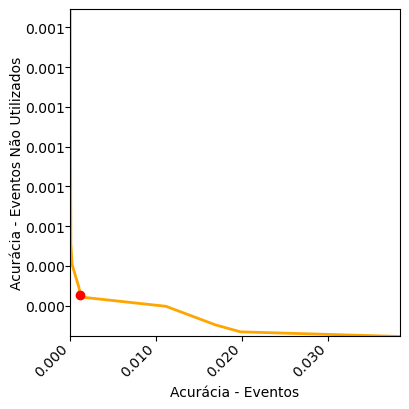

28 0.00032734946308843327 0.0011758212751661334


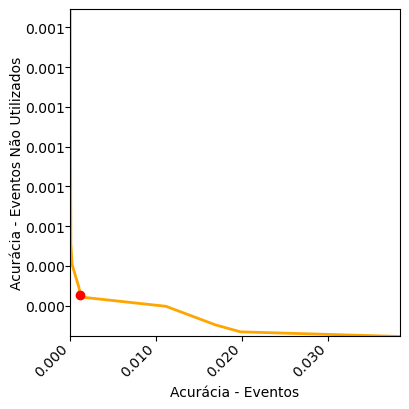

29 0.00032734946308843327 0.0011758212751661334


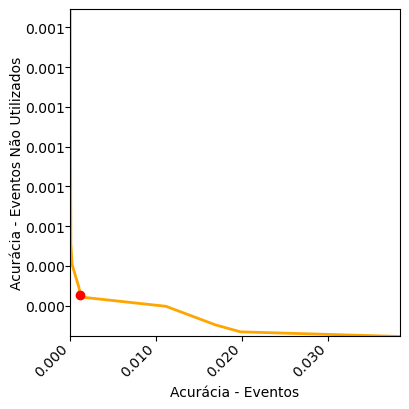

30 0.00032734946308843327 0.0011758212751661334


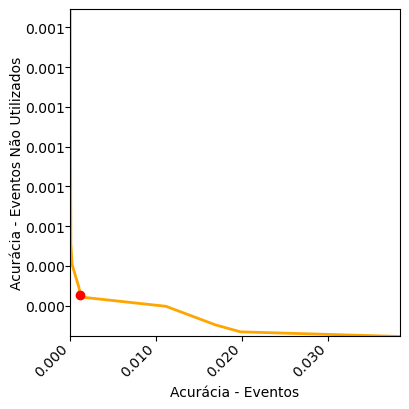

31 0.00034488604146820645 0.0010318431598397293


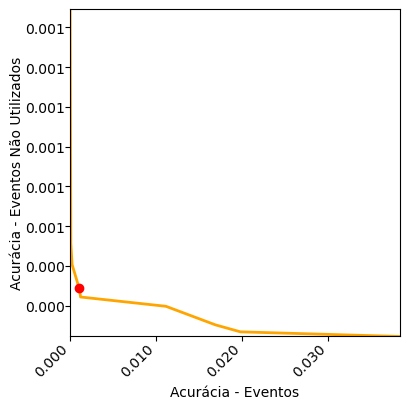

32 0.00032734946308843327 0.0011758212751661334


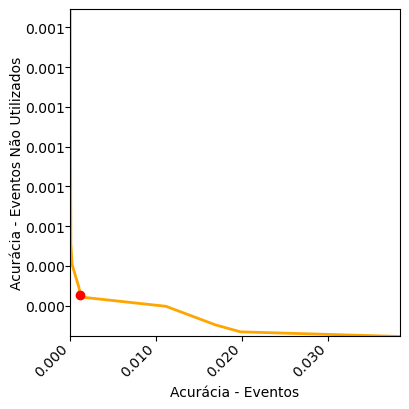

33 0.00032734946308843327 0.0011758212751661334


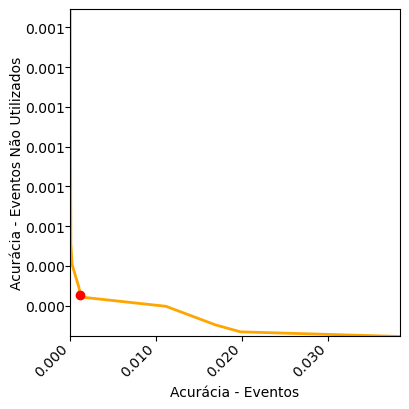

34 0.00032734946308843327 0.0011758212751661334


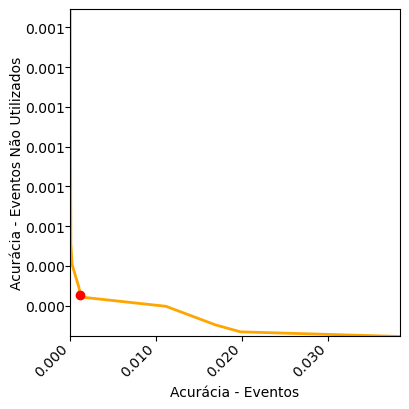

35 0.00022212999281001622 0.038346171381949956


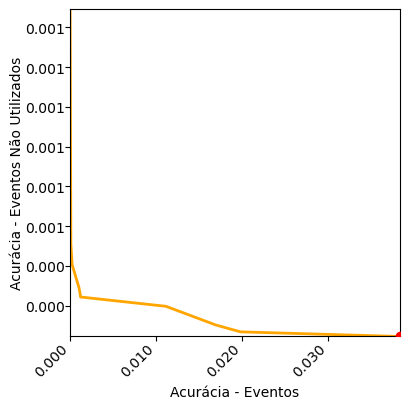

36 0.00032734946308843327 0.0011758212751661334


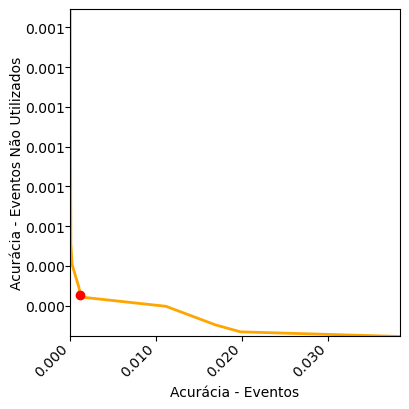

37 0.00032734946308843327 0.0011758212751661334


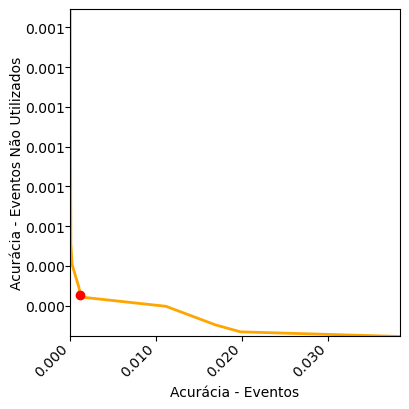

38 0.0003215039369618422 0.0012118158039977622


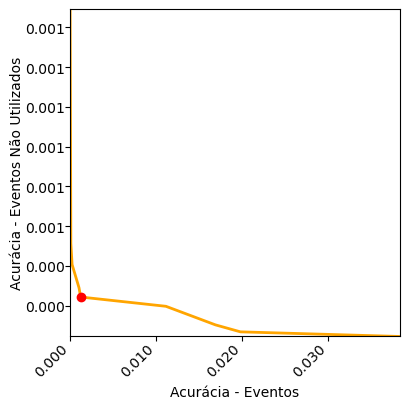

39 0.0003215039369618422 0.0012118158039977622


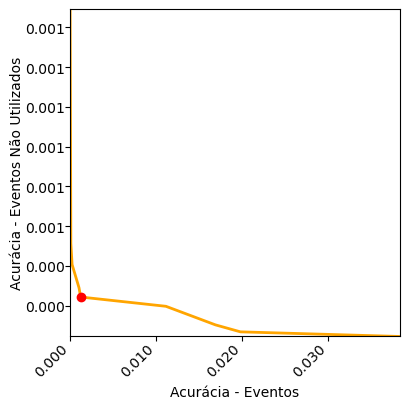

40 0.00032734946308843327 0.0011758212751661334


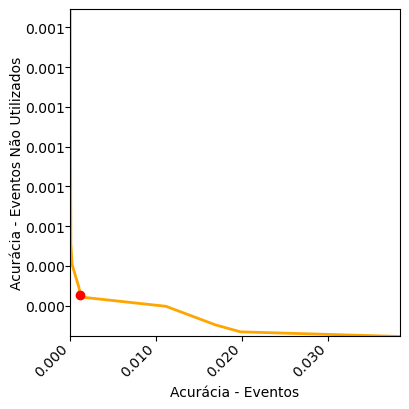

41 0.00022212999281001622 0.038346171381949956


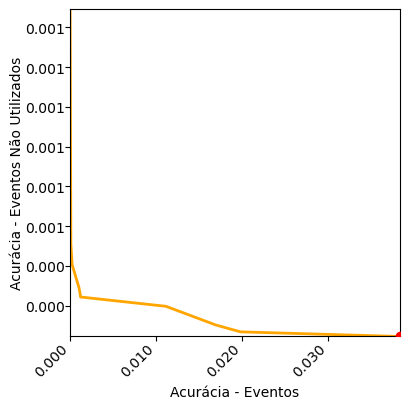

42 0.00040334130273400604 0.00022796534926694534


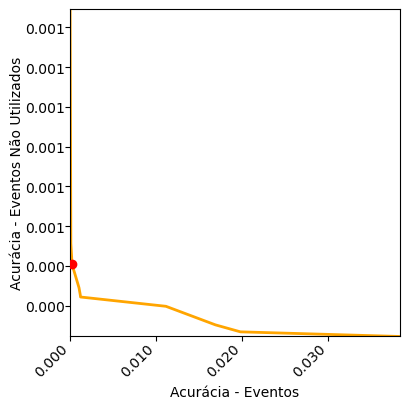

43 0.0003215039369618422 0.0012118158039977622


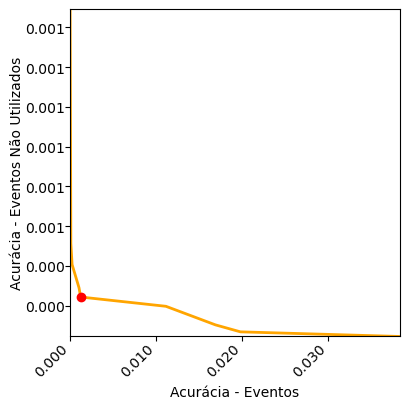

44 0.00032734946308843327 0.0011758212751661334


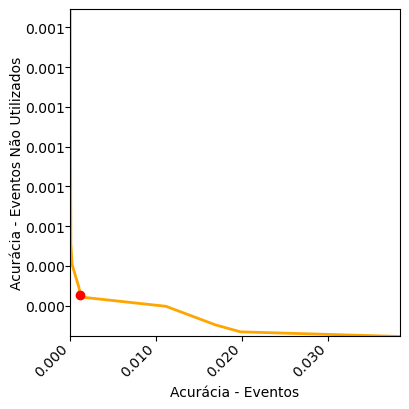

45 0.00040334130273400604 0.00022796534926694534


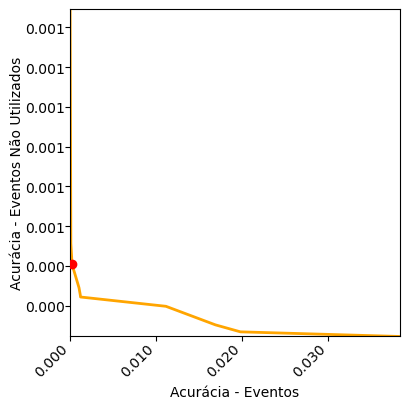

46 0.00022212999281001622 0.038346171381949956


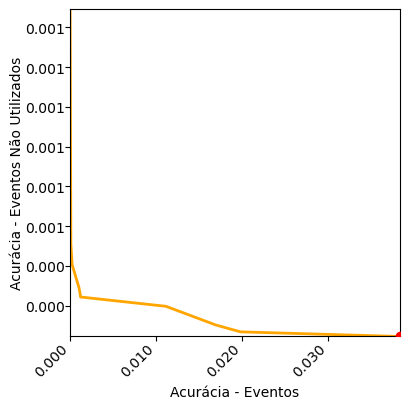

47 0.00032734946308843327 0.0011758212751661334


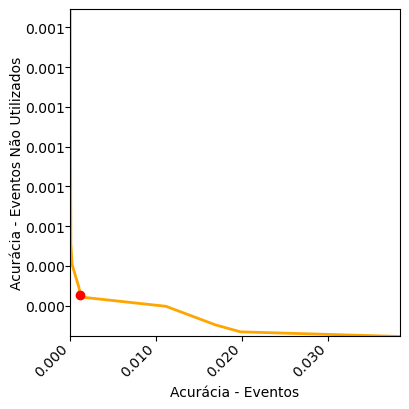

48 0.00034488604146820645 0.0010318431598397293


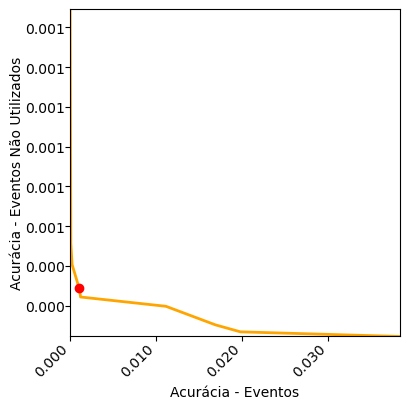

49 0.0003215039369618422 0.0012118158039977622


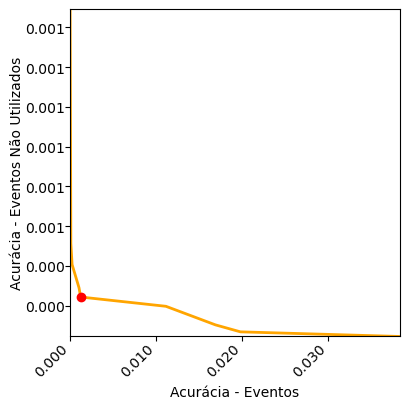

50 0.00032734946308843327 0.0011758212751661334


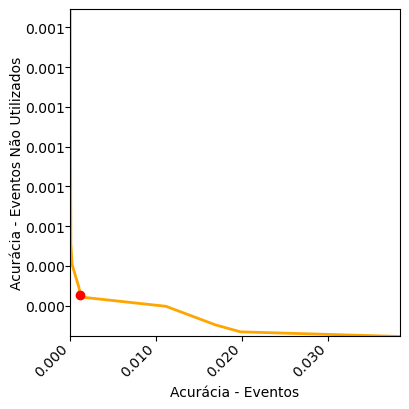

51 0.00040334130273400604 0.00022796534926694534


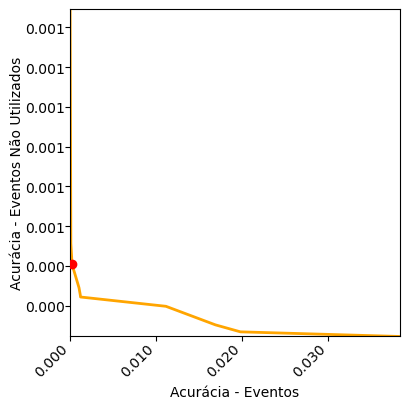

52 0.00023382104506319834 0.01979699085738973


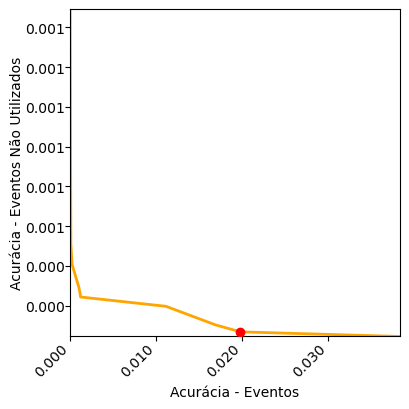

53 0.00032734946308843327 0.0011758212751661334


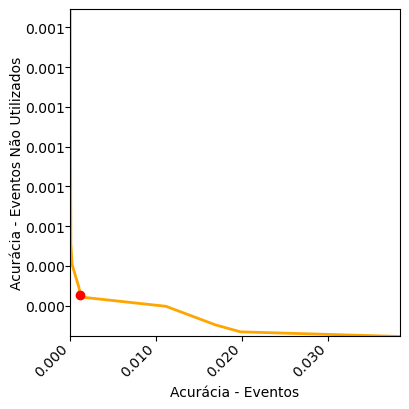

54 0.0002513576234428605 0.016893432198305858


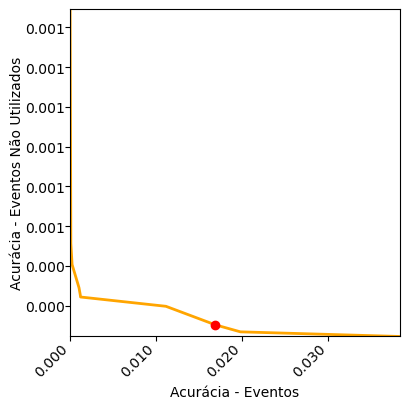

55 0.00023382104506319834 0.01979699085738973


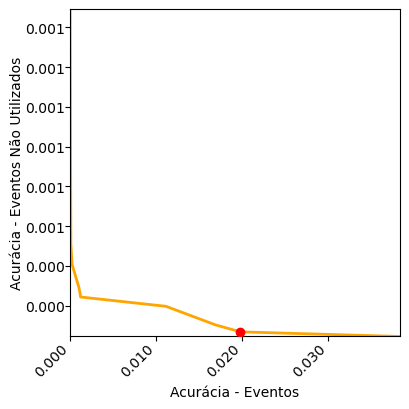

56 0.00022212999281001622 0.038346171381949956


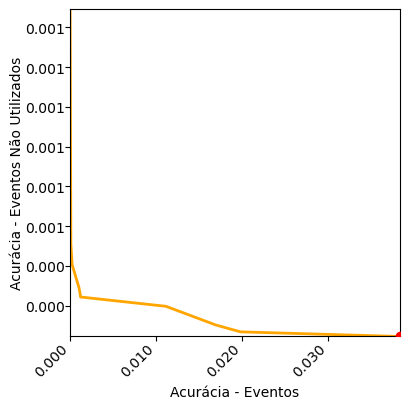

57 0.00034488604146820645 0.0010318431598397293


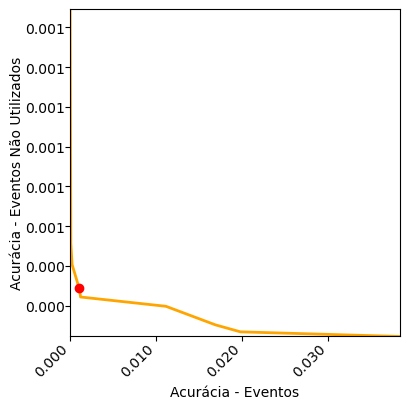

58 0.00029812183245547796 0.011134307585247027


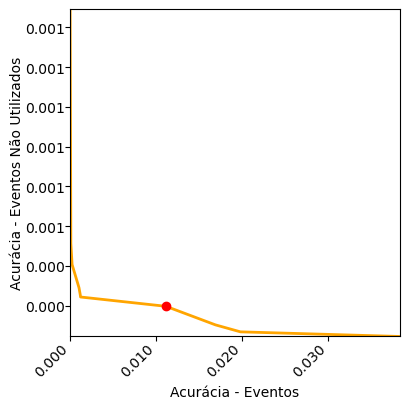

59 0.00040334130273400604 0.00022796534926694534


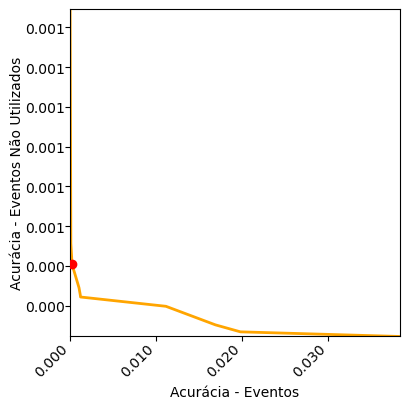

60 0.00032734946308843327 0.0011758212751661334


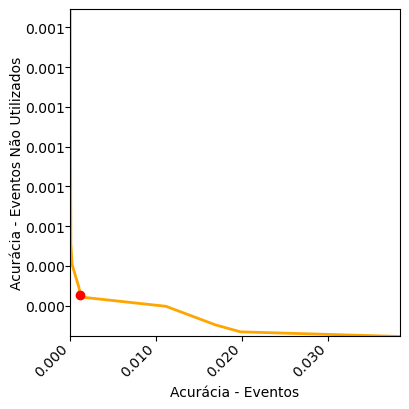

61 0.00032734946308843327 0.0011758212751661334


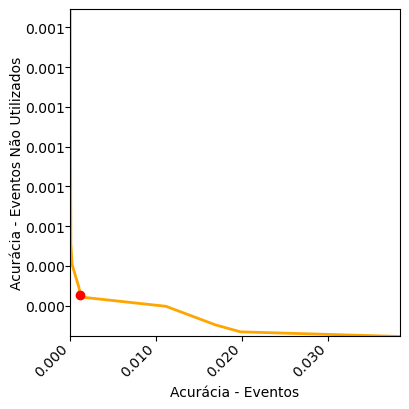

62 0.00029812183245547796 0.011134307585247027


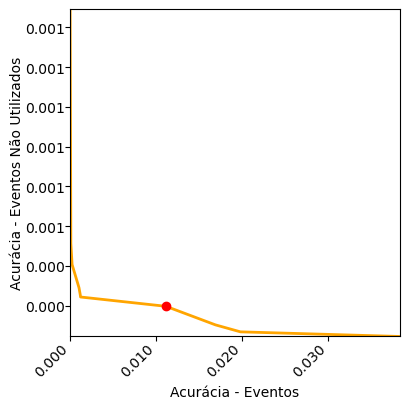

63 0.00032734946308843327 0.0011758212751661334


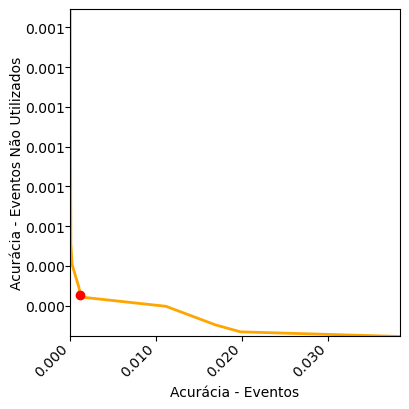

64 0.0002513576234428605 0.016893432198305858


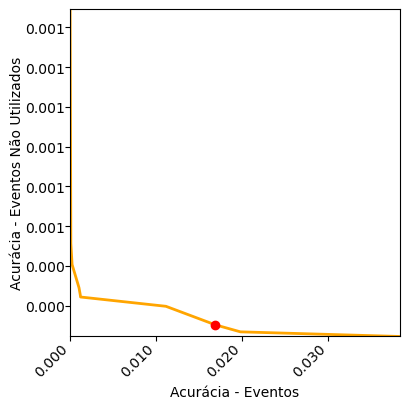

65 0.0002513576234428605 0.016893432198305858


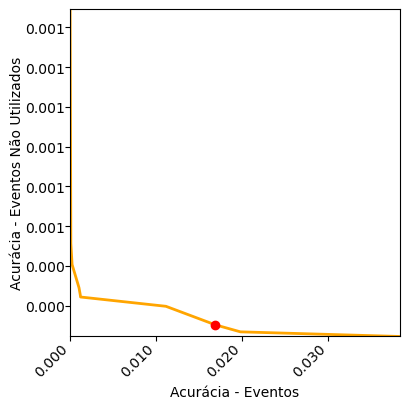

66 0.00034488604146820645 0.0010318431598397293


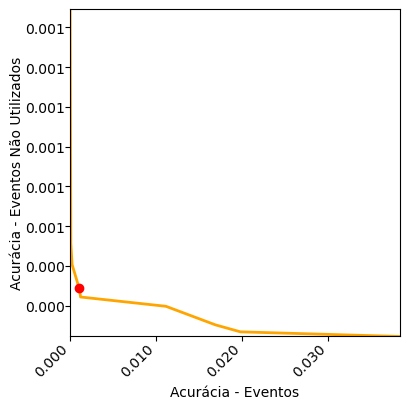

67 0.00034488604146820645 0.0010318431598397293


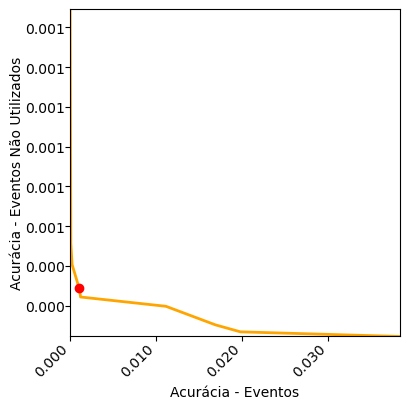

68 0.00032734946308843327 0.0011758212751661334


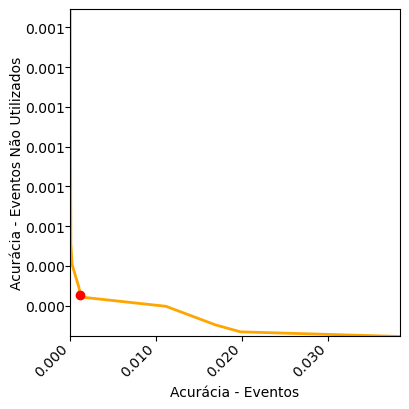

69 0.0002513576234428605 0.016893432198305858


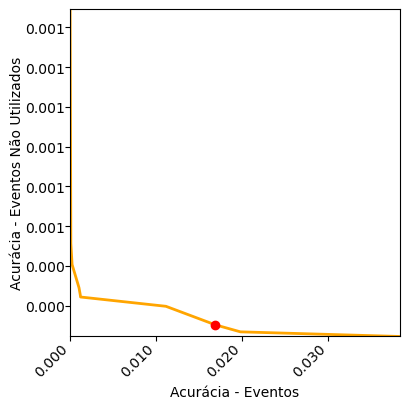

70 0.00032734946308843327 0.0011758212751661334


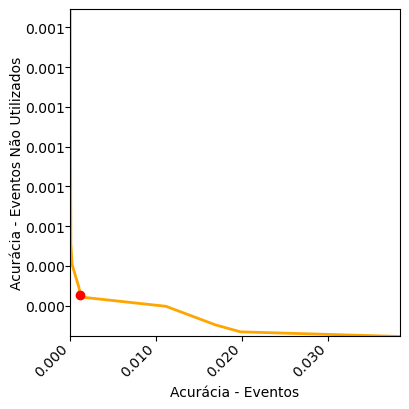

71 0.00023382104506319834 0.01979699085738973


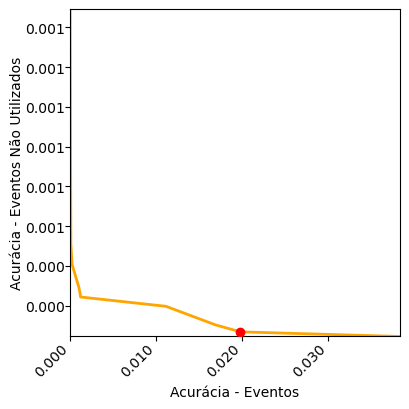

72 0.00032734946308843327 0.0011758212751661334


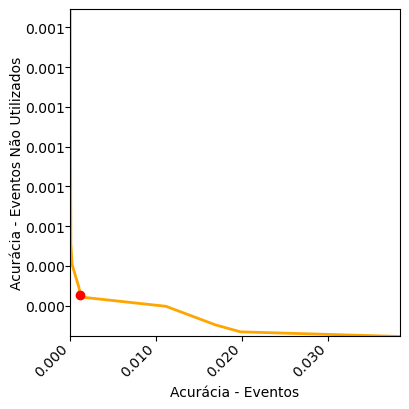

73 0.00032734946308843327 0.0011758212751661334


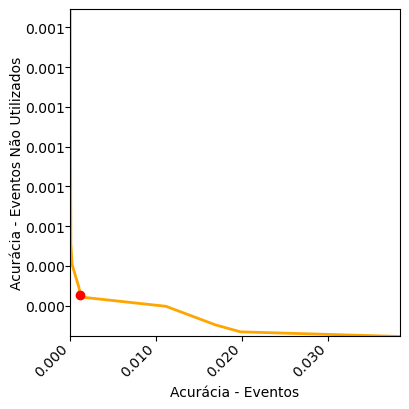

74 0.00032734946308843327 0.0011758212751661334


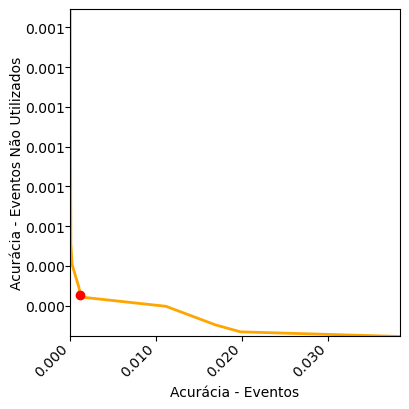

75 0.00032734946308843327 0.0011758212751661334


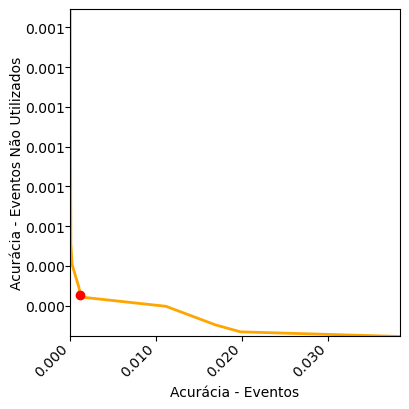

76 0.00032734946308843327 0.0011758212751661334


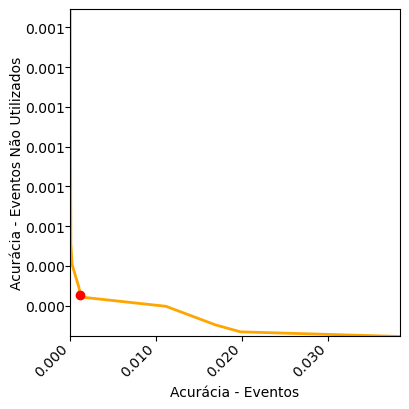

77 0.0003215039369618422 0.0012118158039977622


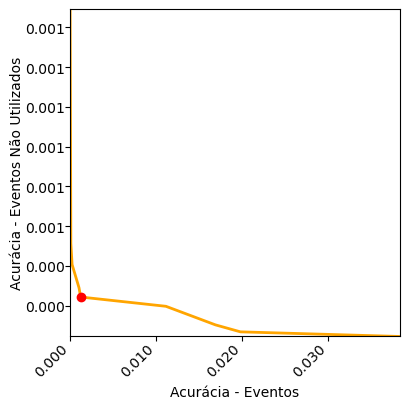

78 0.00032734946308843327 0.0011758212751661334


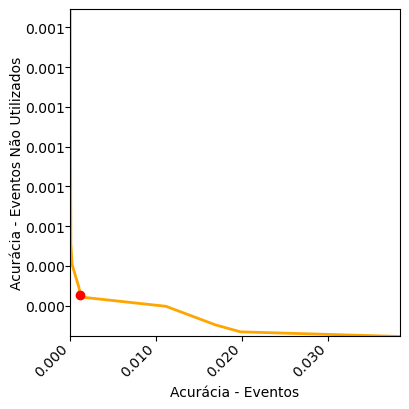

79 0.00032734946308843327 0.0011758212751661334


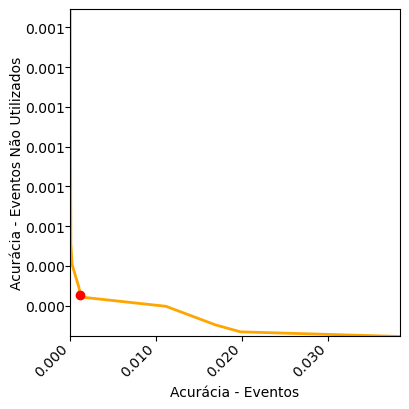

80 0.00032734946308843327 0.0011758212751661334


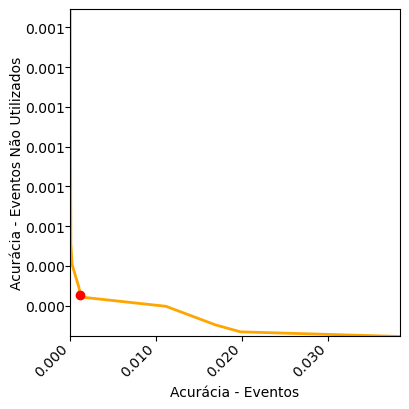

81 0.00040334130273400604 0.00022796534926694534


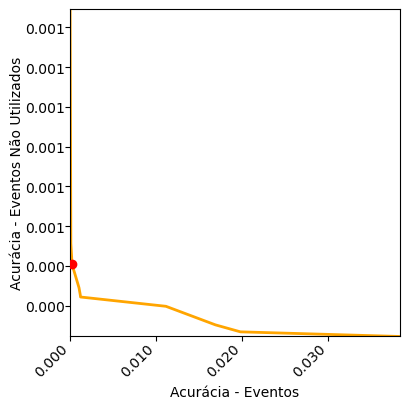

82 0.00032734946308843327 0.0011758212751661334


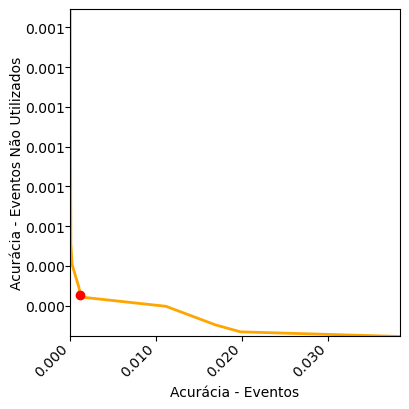

83 0.00034488604146820645 0.0010318431598397293


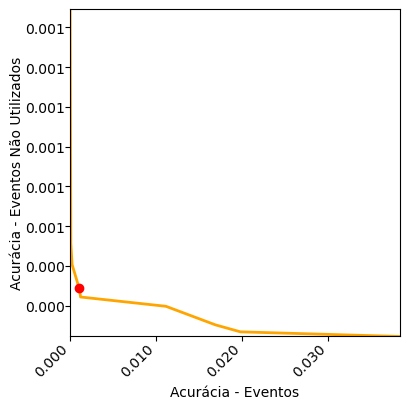

84 0.0002513576234428605 0.016893432198305858


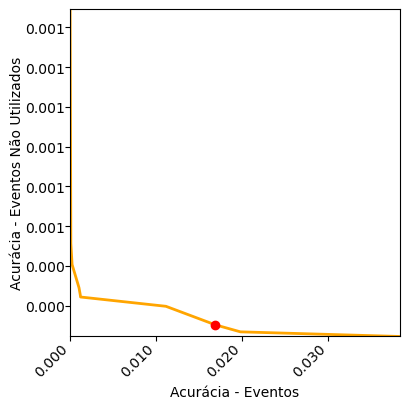

85 0.00032734946308843327 0.0011758212751661334


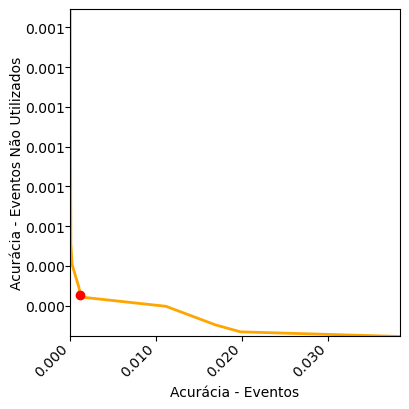

86 0.0003215039369618422 0.0012118158039977622


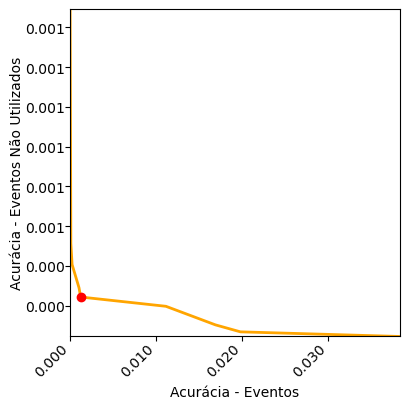

87 0.00032734946308843327 0.0011758212751661334


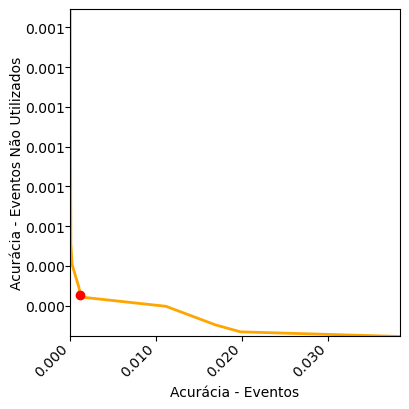

88 0.00032734946308843327 0.0011758212751661334


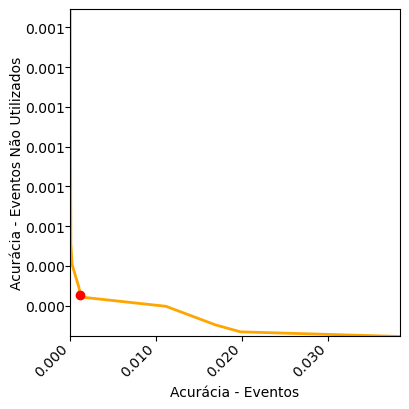

89 0.00032734946308843327 0.0011758212751661334


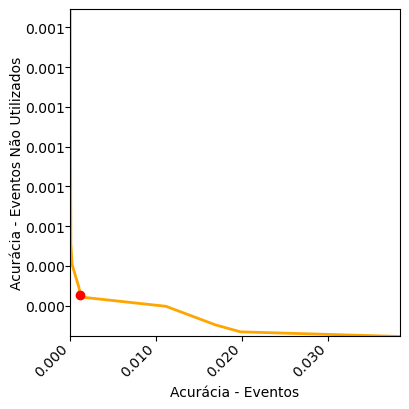

90 0.00032734946308843327 0.0011758212751661334


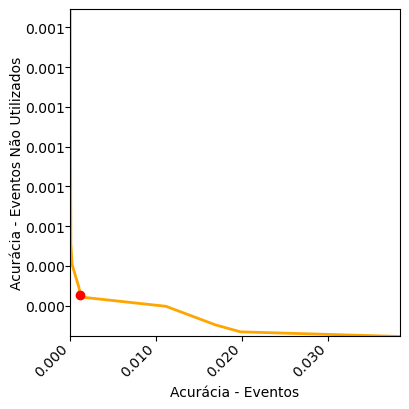

91 0.00032734946308843327 0.0011758212751661334


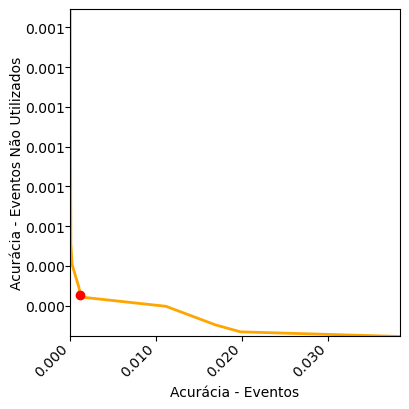

92 0.00032734946308843327 0.0011758212751661334


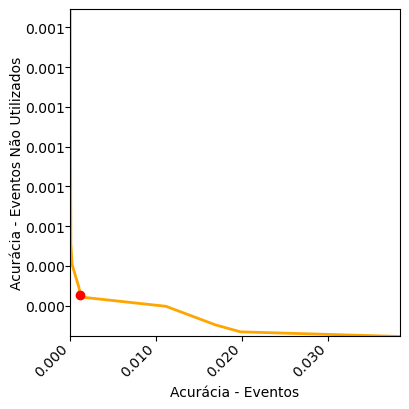

93 0.00032734946308843327 0.0011758212751661334


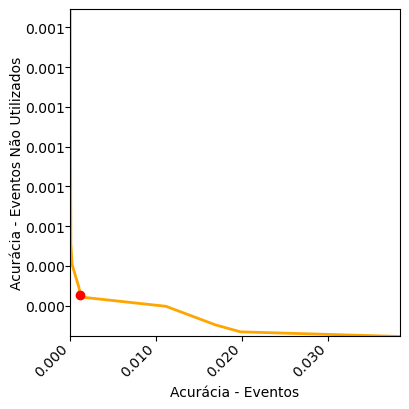

94 0.00040334130273400604 0.00022796534926694534


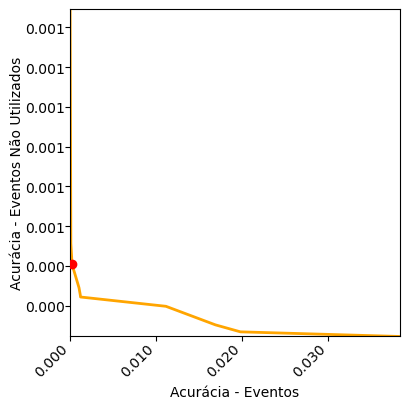

95 0.00032734946308843327 0.0011758212751661334


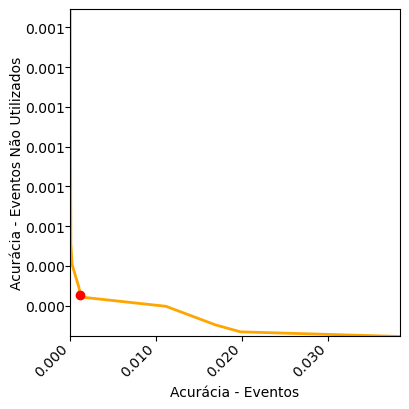

96 0.00032734946308843327 0.0011758212751661334


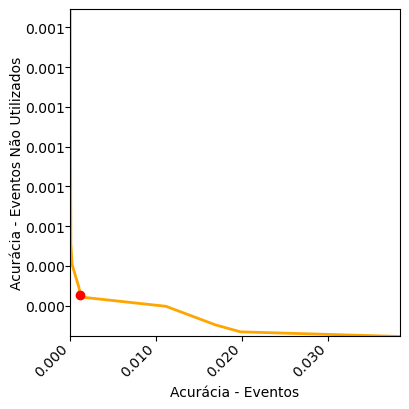

97 0.00022212999281001622 0.038346171381949956


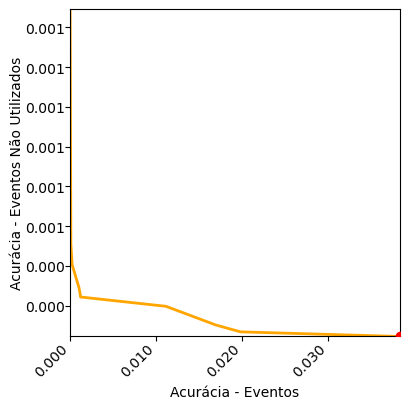

98 0.00023382104506319834 0.01979699085738973


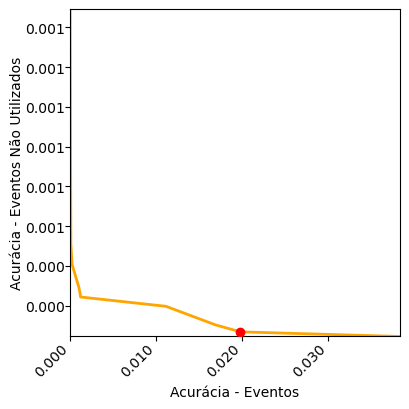

99 0.00032734946308843327 0.0011758212751661334


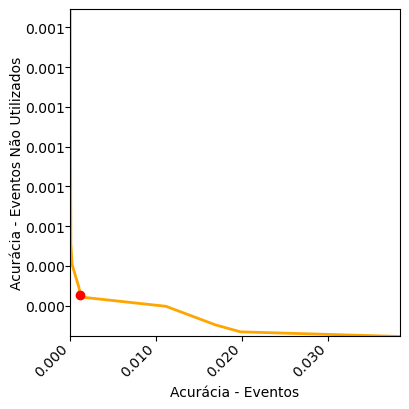

In [107]:
for i in range(0,100):
    plotar2(res1, i)

In [103]:
# Função objetivo selecionada
res1.F[7]

array([0.0003215 , 0.00121182])

In [109]:
# Features correspondente
res1.X[7]

array([0.80559275, 0.40484131, 0.14558903, 0.65217691, 0.34781672,
       0.14183958, 0.62057116, 0.31906734, 0.33939716, 0.96545658,
       0.76577301, 0.04256242, 0.56849119, 0.37459176, 0.92373121,
       0.57835645, 0.21306514, 0.88586909, 0.28794698, 0.3106081 ,
       0.23192346, 0.6598727 , 0.4947111 , 0.09701518, 0.50086325,
       0.38979162, 0.86043735, 0.44390839, 0.44475649, 0.20503392,
       0.35576179])

In [113]:
colunas = aX_train.columns
# Verificar as colunas que são maiores que 0.5
for i, valor in enumerate(res1.X[7]):
    print(i, valor, colunas[i])
    

0 0.805592750115824 Total Fwd Pkts
1 0.4048413142393144 Total Fwd Vol
2 0.14558902554182074 Total Bwd Pkts
3 0.6521769124733644 Total Bwd Vol
4 0.3478167192547512 Fwd Pkt Len Std
5 0.14183957833375568 Bwd Pkt Len Max
6 0.6205711608105945 Bwd Pkt Len Std
7 0.31906734017007515 Fwd IAT Mean
8 0.33939715567471135 Fwd IAT Max
9 0.9654565840285656 Fwd IAT Std
10 0.7657730147967562 Bwd IAT Max
11 0.042562422227959786 Bwd IAT Std
12 0.5684911893860076 Duration
13 0.37459175504765724 Active Min
14 0.9237312142518398 Active Mean
15 0.5783564471310888 Active Max
16 0.21306514358875583 Active Std
17 0.8858690929468074 Idle Min
18 0.2879469801380569 Idle Mean
19 0.3106081028529314 Idle Max
20 0.23192346299317035 Idle Std
21 0.6598727007747258 SFlow Fwd Pkts
22 0.4947110984515314 SFlow Fwd Bytes
23 0.09701517633385345 SFlow Bwd Pkts
24 0.500863248392633 SFlow bwd Bytes
25 0.3897916233033042 FPSH Count
26 0.8604373545742141 BPSH Count
27 0.44390838730368465 FURG Count
28 0.4447564941098581 BURG Count

In [115]:
# Features selecionadas
for i, valor in enumerate(res1.X[7]):
    if valor > 0.5:
        print(i, valor, colunas[i])

0 0.805592750115824 Total Fwd Pkts
3 0.6521769124733644 Total Bwd Vol
6 0.6205711608105945 Bwd Pkt Len Std
9 0.9654565840285656 Fwd IAT Std
10 0.7657730147967562 Bwd IAT Max
12 0.5684911893860076 Duration
14 0.9237312142518398 Active Mean
15 0.5783564471310888 Active Max
17 0.8858690929468074 Idle Min
21 0.6598727007747258 SFlow Fwd Pkts
24 0.500863248392633 SFlow bwd Bytes
26 0.8604373545742141 BPSH Count


In [117]:
# Features a serem removidas
remove_colunas = []
for i, valor in enumerate(res1.X[7]):
    if valor < 0.5:
        print(i, valor, colunas[i])
        remove_colunas.append(colunas[i])

1 0.4048413142393144 Total Fwd Vol
2 0.14558902554182074 Total Bwd Pkts
4 0.3478167192547512 Fwd Pkt Len Std
5 0.14183957833375568 Bwd Pkt Len Max
7 0.31906734017007515 Fwd IAT Mean
8 0.33939715567471135 Fwd IAT Max
11 0.042562422227959786 Bwd IAT Std
13 0.37459175504765724 Active Min
16 0.21306514358875583 Active Std
18 0.2879469801380569 Idle Mean
19 0.3106081028529314 Idle Max
20 0.23192346299317035 Idle Std
22 0.4947110984515314 SFlow Fwd Bytes
23 0.09701517633385345 SFlow Bwd Pkts
25 0.3897916233033042 FPSH Count
27 0.44390838730368465 FURG Count
28 0.4447564941098581 BURG Count
29 0.20503391818650285 Total FHLen
30 0.35576178763230665 Total BHLen


In [119]:
# New dataset
path = 'dataset/eventos_dataset_ok/exp1/'
path_out = 'dataset/eventos_dataset_final/'

df_train2 = pd.read_csv(path+'train.csv')
X_train2 = df_train2.drop(columns=remove_colunas) 

df_test2 = pd.read_csv(path+'test.csv')
X_test2 = df_test2.drop(columns=remove_colunas)

df_test_ev2 = pd.read_csv(path+'test_evento.csv')
X_test_ev2 = df_test_ev2.drop(columns=remove_colunas)

X_train2.to_csv(path_out + '/train.csv', index=False)
X_test2.to_csv(path_out + '/test.csv', index=False)
X_test_ev2.to_csv(path_out + '/test_ev.csv', index=False)

In [121]:
path = 'dataset/all3/wapiti/'
df_train2 = pd.read_csv(path+'train.csv')
len(df_train2.columns)

32

In [125]:
eventos = ['ackscan','bruteforcedirb','cmsscan','dosddos','fullconnectscan','icmpechodiscover','mysqlbruteforces','nikto','scanvuln','ssh_a','stealthscan','synscan','udpscan','wapiti','dns','http','smtp','snmp','ssh']
path = 'dataset/all3/'
path_out = 'dataset/eventos_dataset_final/'
for evento in eventos:
    
    print(evento)

    df_train = pd.read_csv(path + '/'+evento+'/train.csv')
    df_test = pd.read_csv(path + '/'+evento+'/test.csv')
    df_val = pd.read_csv(path + '/'+evento+'/val.csv')

    df_train = df_train.drop(columns=remove_colunas)
    df_test = df_test.drop(columns=remove_colunas)
    df_val = df_val.drop(columns=remove_colunas)

    os.mkdir(path_out+'/'+evento)

    print(df_train.shape, df_test.shape, df_val.shape)

    df_train.to_csv(path_out + '/'+ evento +'/train.csv', index=False)
    df_test.to_csv(path_out + '/'+ evento +'/test.csv', index=False)
    df_val.to_csv(path_out + '/'+ evento +'/val.csv', index=False)

ackscan
(5295228, 13) (3971421, 13) (3971422, 13)
bruteforcedirb
(192633, 13) (144475, 13) (144475, 13)
cmsscan
(435409, 13) (326557, 13) (326558, 13)
dosddos
(293934, 13) (220451, 13) (220451, 13)
fullconnectscan
(5283592, 13) (3962694, 13) (3962694, 13)
icmpechodiscover
(5295228, 13) (3971421, 13) (3971422, 13)
mysqlbruteforces
(28084, 13) (21064, 13) (21064, 13)
nikto
(653045, 13) (489784, 13) (489785, 13)
scanvuln
(5505686, 13) (4129265, 13) (4129266, 13)
ssh_a
(4897, 13) (3673, 13) (3673, 13)
stealthscan
(5294848, 13) (3971136, 13) (3971136, 13)
synscan
(5269014, 13) (3951760, 13) (3951761, 13)
udpscan
(20736, 13) (15552, 13) (15553, 13)
wapiti
(596, 13) (448, 13) (448, 13)
dns
(19671, 13) (14753, 13) (14754, 13)
http
(206610, 13) (154957, 13) (154958, 13)
smtp
(114735, 13) (86052, 13) (86052, 13)
snmp
(1106, 13) (830, 13) (830, 13)
ssh
(7314, 13) (5486, 13) (5486, 13)


In [141]:
def salvarMetricas(path, classifier, cm, report, acc):
    with open(path + classifier + ".txt", 'w') as arquivo:
        arquivo.write("###" + classifier + "###\n")
        arquivo.write(str(cm)+"\n")
        arquivo.write(report+"\n")
        arquivo.write(acc+"\n")
        arquivo.write("###"+"\n")
        arquivo.write("\n")
    

In [161]:
def classifyRF(path, evento, X_train, y_train, X_test, y_test):
    
    classifier = "RandomForest_" + evento 
    print(classifier)
    
    model = RandomForestClassifier(n_estimators=100, random_state=16)
    model.fit(X_train ,y_train)

    # Salvando o modelo em um arquivo .pkl usando pickle
    with open(path + classifier + '.pkl', 'wb') as arquivo:
        pickle.dump(model, arquivo)
    
    # Fazer previsões
    y_pred = model.predict(X_test)
    
    # Gerar matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    
    print(cm)
    
    #report = classification_report(y_test, y_pred, target_names=['ataque','normal'])
    report = "Única Classe"
    
    print(report)

    accuracy = accuracy_score(y_test, y_pred)
    acc = f'Acurácia do modelo: {accuracy * 100:.2f}%'
    print(acc)
    print("\n")

    salvarMetricas(path, classifier, cm, report, acc)

In [135]:
path = 'dataset/eventos_dataset_final/'
train_ok = pd.read_csv(path+'train.csv')
print(train_ok.shape)

X_train_ok = train_ok.drop('Label', axis=1) 
y_train_ok = train_ok['Label']  

print(X_train_ok.shape, y_train_ok.shape)

#train_ok.head()

(6636, 13)
(6636, 12) (6636,)


In [163]:
import pandas as pd
import numpy as np
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import matplotlib.pyplot as plt

eventos = ['ackscan','bruteforcedirb','cmsscan','dosddos','fullconnectscan','icmpechodiscover','mysqlbruteforces','nikto','scanvuln','ssh_a','stealthscan','synscan','udpscan','wapiti','dns','http','smtp','snmp','ssh']
eventos = ['smtp', 'ssh', 'udpscan']

path_out = 'dataset/eventos_dataset_final/'

for evento in eventos:
    print(evento)
    
    test_ok = pd.read_csv(path_out+'/'+evento+'/test.csv')
    X_test_ok = test_ok.drop('Label', axis=1) 
    y_test_ok = test_ok['Label']  
    
    classifyRF(path_out+"/model/", evento, X_train_ok, y_train_ok, X_test_ok, y_test_ok)

smtp
RandomForest_smtp
[[86052]]
Única Classe
Acurácia do modelo: 100.00%


ssh
RandomForest_ssh
[[5486]]
Única Classe
Acurácia do modelo: 100.00%


udpscan
RandomForest_udpscan
[[15552]]
Única Classe
Acurácia do modelo: 100.00%




In [167]:
import pandas as pd
import numpy as np
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

path_out = 'dataset/eventos_dataset_final/'
X_train_ok, y_train_ok, X_test_ok, y_test_ok, X_test_ev_ok, y_test_ev_ok = LoadFeatures(path_out)

# Teste Desconhecidos
classifyRF(path_out, "Enventos_Desconhecidos", X_train_ok, y_train_ok, X_test_ok, y_test_ok)

# Teste Eventos Conhecidos
classifyRF(path_out, "Enventos_Conhecidos", X_train_ok, y_train_ok, X_test_ev_ok, y_test_ev_ok)

RandomForest_Enventos_Desconhecidos
[[159243  10758]
 [     0   1070]]
Única Classe
Acurácia do modelo: 93.71%


RandomForest_Enventos_Conhecidos
[[81806     4]
 [    1  1535]]
Única Classe
Acurácia do modelo: 99.99%


